<a href="https://colab.research.google.com/github/ardi-cahyono/proyek-nlp-tf/blob/main/ardicahyono_proyek_model_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Menuliskan data diri
print('Proyek Pertama : Membuat Model NLP dengan TensorFlow')
print('Nama Lengkap   : Ardi Cahyono')
print('Username       : ardi_cahy37')
print('Email          : 116190016@student.upnyk.ac.id')
print('Domisili       : Kabupaten Sleman, Daerah Istimewa Yogyakarta')

Proyek Pertama : Membuat Model NLP dengan TensorFlow
Nama Lengkap   : Ardi Cahyono
Username       : ardi_cahy37
Email          : 116190016@student.upnyk.ac.id
Domisili       : Kabupaten Sleman, Daerah Istimewa Yogyakarta


In [3]:
# Mengunduh dataset dari repo github
!wget --no-check-certificate \
   https://raw.githubusercontent.com/ardi-cahyono/proyek-nlp-tf/main/IMDB%20Dataset.zip \
   -O /tmp/IMDB_review.zip

--2022-01-11 02:37:28--  https://raw.githubusercontent.com/ardi-cahyono/proyek-nlp-tf/main/IMDB%20Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25347925 (24M) [application/zip]
Saving to: ‘/tmp/IMDB_review.zip’

/tmp/IMDB_review.zi 100%[===================>]  24.17M  --.-KB/s    in 0.1s    

2022-01-11 02:37:33 (167 MB/s) - ‘/tmp/IMDB_review.zip’ saved [25347925/25347925]



In [4]:
# Melakukan ektraksi pada file zip
import zipfile,os
local_zip = '/tmp/IMDB_review.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# Mengubah dataset menjadi dataframe
import pandas as pd

df = pd.read_csv('/tmp/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
# Melakukan one-hot-encoding untuk merubah label dari data kategorikal menjadi data numerik
sentiment = pd.get_dummies(df.sentiment)
df_baru = pd.concat([df, sentiment], axis=1)
df_baru = df_baru.drop(columns='sentiment')
df_baru

,review,negative,positive
0,One of the other reviewers has mentioned that ...,0,1
1,A wonderful little production. <br /><br />The...,0,1
2,I thought this was a wonderful way to spend ti...,0,1
3,Basically there's a family where a little boy ...,1,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,1
...,...,...,...
49995,I thought this movie did a down right good job...,0,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1,0
49997,I am a Catholic taught in parochial elementary...,1,0
49998,I'm going to have to disagree with the previou...,1,0


In [7]:
review = df_baru['review'].values
label = df_baru[['negative', 'positive']]

In [8]:
# Membagi data latih dan data uji
from sklearn.model_selection import train_test_split
review_latih, review_uji, label_latih, label_uji = train_test_split(review, label, test_size=0.2)

In [9]:
# Mengubah dataset menjadi data numerik
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(num_words=6000, oov_token='x')
tokenizer.fit_on_texts(review_latih)
tokenizer.fit_on_texts(review_uji)

sekuens_latih = tokenizer.texts_to_sequences(review_latih)
sekuens_uji = tokenizer.texts_to_sequences(review_uji)

padded_latih = pad_sequences(sekuens_latih)
padded_uji = pad_sequences(sekuens_uji)

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

model = Sequential([
    Embedding(input_dim=6000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')         
])

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          96000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 133,442
Trainable params: 133,442
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Membuat fungsi callback untuk menghentikan proses trainig saat ACCURACY mencapai 90%
import tensorflow as tf
MAX_ACCURACY = 0.9

class stopMytrain(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > MAX_ACCURACY):
      print("\nAkurasi yang diinginkan telah tercapai")
      self.model.stop_training = True

# Menginstansiasi objek callback
callbacks = stopMytrain()

In [14]:
hist = model.fit(padded_latih, label_latih, epochs=50, validation_data=(padded_uji, label_uji), verbose=2, callbacks=[callbacks])

Epoch 1/50
1250/1250 - 1714s - loss: 0.3753 - accuracy: 0.8301 - val_loss: 0.2849 - val_accuracy: 0.8805 - 1714s/epoch - 1s/step
Epoch 2/50
1250/1250 - 1707s - loss: 0.2666 - accuracy: 0.8953 - val_loss: 0.2746 - val_accuracy: 0.8909 - 1707s/epoch - 1s/step
Epoch 3/50

Akurasi yang diinginkan telah tercapai
1250/1250 - 1721s - loss: 0.2178 - accuracy: 0.9154 - val_loss: 0.2812 - val_accuracy: 0.8806 - 1721s/epoch - 1s/step


In [15]:
# Mengevaluasi akurasi dan loss dari model
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))

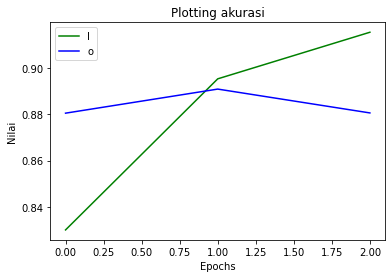

In [16]:
# Memvisualisasi grafik akurasi
plt.plot(epochs, acc, 'g', label='Akurasi Latihan')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Plotting akurasi')
plt.xlabel('Epochs')
plt.ylabel('Nilai')
plt.legend('lower left')
plt.show()

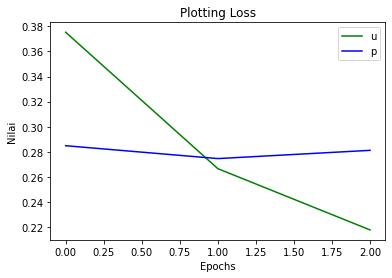

In [17]:
# Memvisualisasi grafik loss
plt.plot(epochs, loss, 'g', label='Loss Latihan')
plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
plt.title('Plotting Loss')
plt.xlabel('Epochs')
plt.ylabel('Nilai')
plt.legend('upper right')
plt.show()